In [58]:
import torch
import torch.nn
import torchinfo
from torchvision import transforms
import torchvision

import os
import zipfile
from pathlib import Path
import requests
import PIL
import random


from  timeit import default_timer as Timer
import matplotlib.pyplot as plt

from typing import List, Tuple

from data_setup import create_dataloaders
from engine import train


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu" 
device

'cuda'

In [16]:
GITHUB_LINK = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exist")

else:
    print(f"Did not find {image_path} directory. Creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(GITHUB_LINK)
        f.write(request.content)
    
    with zipfile.ZipFile(data_path / "pizza_steak_sushi", "r") as z:
        print(f"Unzipping pizza, steak, sushi data...")
        z.extractall(image_path)
    

data\pizza_steak_sushi directory exist


In [21]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [22]:
manual_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [23]:

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir= train_dir,
    test_dir= test_dir,
    transform=manual_transforms,
    batch_size=32
)

In [24]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [25]:
auto_transfroms = weights.transforms()
auto_transfroms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [27]:
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transfroms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1a553df7490>,
 ['pizza', 'steak', 'sushi'])

In [47]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [48]:
torchinfo.summary(
    model, 
    input_size=(32,3,224,244),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 244]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 244]    [32, 1280, 7, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 244]    [32, 32, 112, 122]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 244]    [32, 32, 112, 122]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 122]   [32, 32, 112, 122]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 122]   [32, 32, 112, 122]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 122]   [32, 16, 112

In [49]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [50]:
torch.manual_seed(57)
torch.cuda.manual_seed(57)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [36]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
torchinfo.summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [51]:
criterion =  torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.003)

In [52]:
torch.manual_seed(57)
torch.cuda.manual_seed(57)

start_time = Timer()

resuts = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=criterion,
    epochs=5,
    device=device
)

end_time = Timer()
print(f"[INFO] Total running time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:13<00:54, 13.72s/it]

Epoch: 1 | train_loss: 0.8910 | train_acc: 0.6953 | test_loss: 0.4767 | test_acc: 0.9271


 40%|████      | 2/5 [00:27<00:41, 13.83s/it]

Epoch: 2 | train_loss: 0.6713 | train_acc: 0.6641 | test_loss: 0.4324 | test_acc: 0.9176


 60%|██████    | 3/5 [00:41<00:27, 13.87s/it]

Epoch: 3 | train_loss: 0.5575 | train_acc: 0.7539 | test_loss: 0.5638 | test_acc: 0.7131


 80%|████████  | 4/5 [00:55<00:13, 13.92s/it]

Epoch: 4 | train_loss: 0.5663 | train_acc: 0.7734 | test_loss: 0.4006 | test_acc: 0.8049


100%|██████████| 5/5 [01:09<00:00, 13.95s/it]

Epoch: 5 | train_loss: 0.3946 | train_acc: 0.8320 | test_loss: 0.3562 | test_acc: 0.8968
[INFO] Total running time: 69.771 seconds


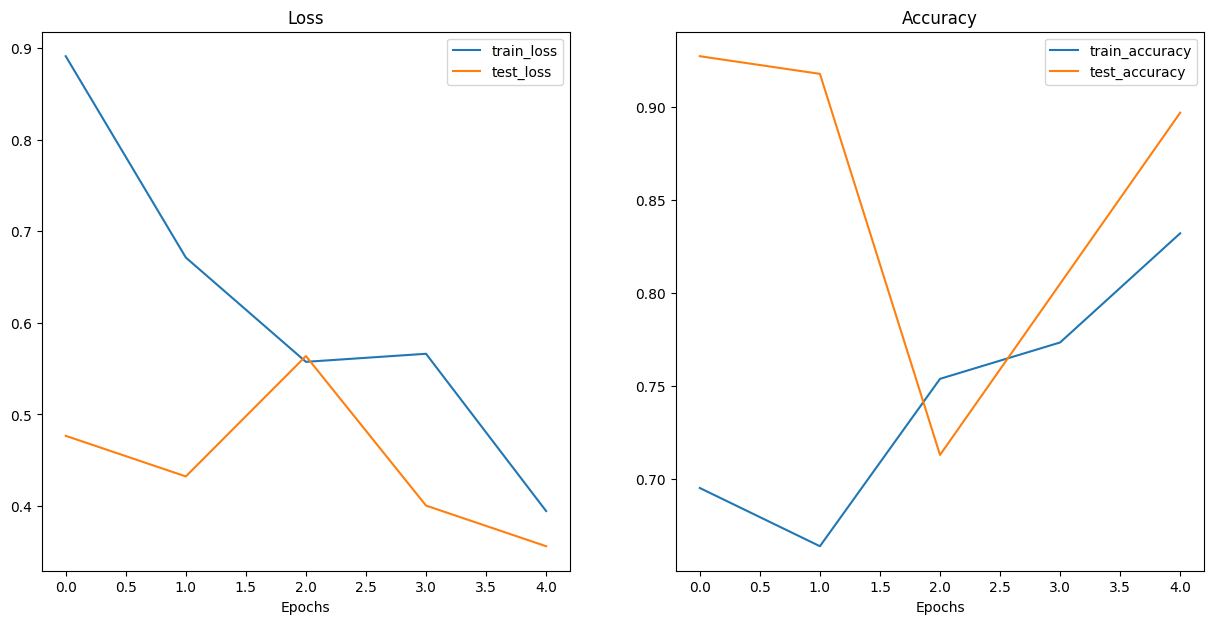

In [53]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(resuts)

In [76]:
import PIL.Image

def pred_and_plot_image(
        model: torch.nn.Module,
        class_names: List[str],
        img_path: str,
        img_size: Tuple[int, int],
        transform: transforms.Compose = None,
        device: torch.device = device,
        ):
    
    img = PIL.Image.open(img_path)

    if transform is not None:
        img_transform = transform

    else:
        img_transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])   
        ])

    model.to(device)

    model.eval()
    with torch.inference_mode():
        transformed_img = img_transform(img).unsqueeze(dim=0)

        transformed_img_pred = model(transformed_img.to(device))

        target_img_pred_probs = torch.softmax(transformed_img_pred, dim=1)

        transformed_img_pred_label = torch.argmax(target_img_pred_probs, dim=1)

    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred Class : {class_names[transformed_img_pred_label]} | Prob : {target_img_pred_probs.max():.3f}")
    plt.axis("off")
    plt.show()

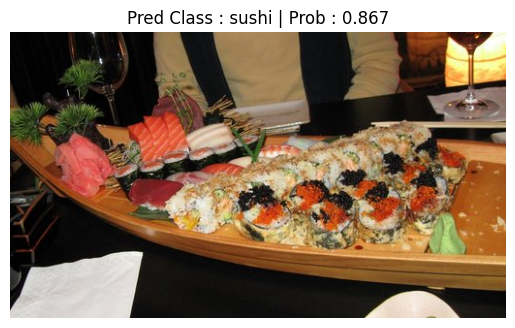

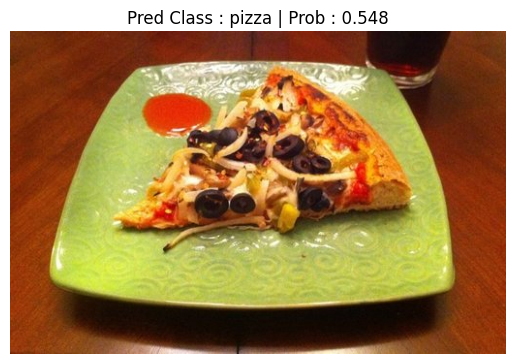

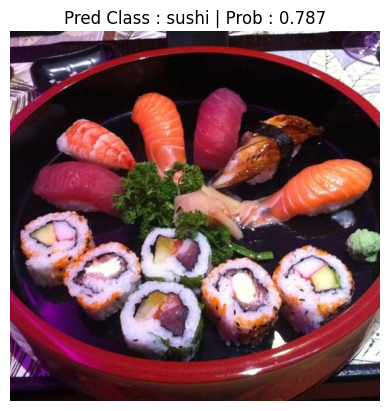

In [78]:
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, class_names=class_names, img_path= image_path, img_size=(224,224), transform=None, device=device)

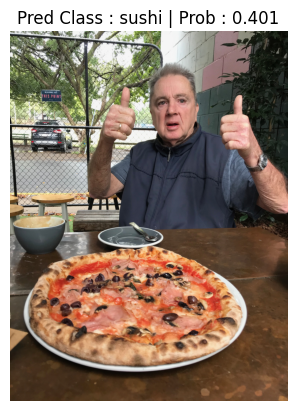

In [82]:
pred_and_plot_image(model= model,
                    img_path= data_path / "04-pizza-dad.jpeg",
                    device=device,
                    img_size=(3024,4032),
                    transform=None,
                    class_names=class_names                    
)

In [86]:
transfer_learning_exerciese_github_link = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb"
transfer_learning_exerciese_path = Path("homework_6.ipynb")

if transfer_learning_exerciese_path.is_file():
    print("[INFO] Exercise notebook already exist")

else:
    print(F"[INFO] Did not find exercise notebook, downloading...")
    
    request = requests.get(transfer_learning_exerciese_github_link)

    with open(transfer_learning_exerciese_path, "wb") as f:
        f.write(request.content)

    print(f"[INFO] Download competed. Notebook is in {transfer_learning_exerciese_path} directory")

[INFO] Did not find exercise notebook, downloading...
[INFO] Download competed. Notebook is in homework_6.ipynb directory
